# Project 3 - Web APIs & Classification

### Problem Statement

Reddit is a collection of online discussion boards known as "subreddits", which cover a variety of topics. The goal of this project is to classify which subreddit a given post came from. 

In this project I will be classifying posts from two subreddits, /r/himym and /r/bigbangtheory. These two subreddits were picked becuase of their similarity in topics and the content in them.

Due to the popularity of both shows, there are many people who already watched the shows, but also some who have no idea what the shows are about. Through this project I hope to identify keywords to help new viewers identify what keywords to search for more information about the show or to classify which post or information belongs to which shows.

##### Key Terms

- The Big Bang Theory will be refer as BBT or The Big Bang Theory interchangably.
- How I Met Your Mother will be refer as HIMYM or How I Met Your Mother interchangably.

---

# Data Cleaning

I this section, through cleaning and exploring the data I removed duplicate posts resulting in HIMYM having a total of 869 posts and The Big Bang Theory to have 1012 posts. Then I decided to used the subreddit, post name, post title and post self text for this project as it most relate to our tropic of predicting which posts belong to which subreddit. 

In [2]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles

from tqdm import tqdm 

import requests
import time
from bs4 import BeautifulSoup

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import regex as re

In [4]:
himym = pd.read_csv('data/himym.csv')
himym1 = pd.read_csv('data/himym_test.csv')

bigbang = pd.read_csv('data/bigbang.csv')
bigbang1 = pd.read_csv('data/bigbang_test.csv')

I decided to pulled each data twice to maximized the number of posts I have to model and used. The data from the same shows will be joined and cleaned.

In [5]:
himym.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,num_crossposts,media,is_video,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,poll_data,author_cakeday
0,0,NaN,HIMYM,NaN,t2_f6huuo,False,NaN,0,False,This submission on a BuzzFeed article called “...,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,HIMYM,NaN,t2_93w6hlvh,False,NaN,0,False,Meme,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,HIMYM,NaN,t2_a2mby5ze,False,NaN,0,False,"I love this scene a lot, so I decided to draw ...",...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,HIMYM,NaN,t2_63lq8zxw,False,NaN,0,False,Unexpected reference,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,HIMYM,NaN,t2_11oa4w,False,NaN,0,False,I don't think so pal...,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
himym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Columns: 115 entries, Unnamed: 0 to author_cakeday
dtypes: bool(26), float64(31), int64(9), object(49)
memory usage: 719.4+ KB


In [7]:
himym = himym.drop(['Unnamed: 0'],axis=1)
himym.shape

(998, 114)

In [8]:
himym.columns

Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
       'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
       ...
       'num_crossposts', 'media', 'is_video', 'is_gallery', 'media_metadata',
       'gallery_data', 'crosspost_parent_list', 'crosspost_parent',
       'poll_data', 'author_cakeday'],
      dtype='object', length=114)

In [9]:
himym['name'].nunique()

848

In [10]:
himym.drop_duplicates(subset ='name', inplace = True) 
himym.shape

(848, 114)

In [11]:
himym_data = himym[['name','subreddit','title','selftext']]
himym_data

,name,subreddit,title,selftext
0,t3_m4nauj,HIMYM,This submission on a BuzzFeed article called “...,NaN
1,t3_m4gi9v,HIMYM,Meme,NaN
2,t3_m46ils,HIMYM,"I love this scene a lot, so I decided to draw ...",NaN
3,t3_m4od13,HIMYM,Unexpected reference,NaN
4,t3_m4ssdc,HIMYM,I don't think so pal...,NaN
...,...,...,...,...
843,t3_l8sy1s,HIMYM,Willem🐸,NaN
844,t3_l9mbr0,HIMYM,I have a theory...,As we all know... the entire story of HIMYM is...
845,t3_l9dg8w,HIMYM,Which character’s career do you like the best?,\n\n[View Poll](https://www.reddit.com/poll/l9...
846,t3_l9qqho,HIMYM,Teds kids,Don’t know if this has been posted here but te...


In [12]:
himym1.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,media_metadata,poll_data,is_gallery,gallery_data,author_cakeday
0,0,NaN,HIMYM,NaN,t2_8as7ubb5,False,NaN,0,False,"""But I... look, I don't, I don't even know if ...",...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,HIMYM,NaN,t2_7uxl8ll6,False,NaN,0,False,Farhampton,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,HIMYM,NaN,t2_afp3wlbm,False,NaN,0,False,"barney, what do you do for living? tell us 😡",...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,HIMYM,NaN,t2_7uxl8ll6,False,NaN,0,False,Marshall is so lame sometimes and yet so funny 🙈🙈,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,HIMYM,NaN,t2_f6huuo,False,NaN,0,False,This submission on a BuzzFeed article called “...,...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
himym1 = himym1.drop(['Unnamed: 0'],axis=1)
himym.shape

(848, 114)

In [14]:
himym_data1 = himym1[['name','subreddit','title','selftext']]
himym_data1

,name,subreddit,title,selftext
0,t3_m5dk47,HIMYM,"""But I... look, I don't, I don't even know if ...",NaN
1,t3_m4xbqg,HIMYM,Farhampton,NaN
2,t3_m50wtk,HIMYM,"barney, what do you do for living? tell us 😡",NaN
3,t3_m5ggeo,HIMYM,Marshall is so lame sometimes and yet so funny 🙈🙈,NaN
4,t3_m4nauj,HIMYM,This submission on a BuzzFeed article called “...,NaN
...,...,...,...,...
974,t3_m0xfm1,HIMYM,Looks like Becky is making a killing selling B...,NaN
975,t3_m0oru2,HIMYM,Can we just have a round of applause for Stell...,NaN
976,t3_m0u4iz,HIMYM,Made me think of Barney,NaN
977,t3_m0yekx,HIMYM,Found this little detail while rewatching the ...,NaN


In [15]:
himym_2 = [himym_data1,himym_data]

himym_all = pd.concat(himym_2)
himym_all.reset_index(inplace=True,drop=True)

In [16]:
himym_all['name'].nunique()

869

In [17]:
himym_all.drop_duplicates(subset ='name', inplace = True) 
himym_all.shape

(869, 4)

In [18]:
himym_all

,name,subreddit,title,selftext
0,t3_m5dk47,HIMYM,"""But I... look, I don't, I don't even know if ...",NaN
1,t3_m4xbqg,HIMYM,Farhampton,NaN
2,t3_m50wtk,HIMYM,"barney, what do you do for living? tell us 😡",NaN
3,t3_m5ggeo,HIMYM,Marshall is so lame sometimes and yet so funny 🙈🙈,NaN
4,t3_m4nauj,HIMYM,This submission on a BuzzFeed article called “...,NaN
...,...,...,...,...
1822,t3_l8sy1s,HIMYM,Willem🐸,NaN
1823,t3_l9mbr0,HIMYM,I have a theory...,As we all know... the entire story of HIMYM is...
1824,t3_l9dg8w,HIMYM,Which character’s career do you like the best?,\n\n[View Poll](https://www.reddit.com/poll/l9...
1825,t3_l9qqho,HIMYM,Teds kids,Don’t know if this has been posted here but te...


In [19]:
bigbang.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,media,is_video,url_overridden_by_dest,crosspost_parent_list,link_flair_template_id,crosspost_parent,poll_data,media_metadata,is_gallery,gallery_data
0,0,NaN,bigbangtheory,Hi all! \nI made a The Big Bang Theory Discor...,t2_5fhfdvh8,False,NaN,0,False,Official Discord Server for r/bigbangtheory!,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,bigbangtheory,They had a great moment seasons ago with the w...,t2_4cyhbxdf,False,NaN,0,False,S11 E05: Loved seeing Amy and Howard get along...,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,bigbangtheory,NaN,t2_a6q9ad2x,False,NaN,0,False,😃,...,NaN,False,https://i.redd.it/t77yypx90rm61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,bigbangtheory,NaN,t2_4o0czq,False,NaN,0,False,I have lost countless hours searching for the ...,...,NaN,False,https://i.redd.it/tgp5op6pzpm61.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,bigbangtheory,NaN,t2_569wqhij,False,NaN,0,False,Sheldon would flip out!,...,NaN,False,https://i.redd.it/2l40od5nnrm61.jpg,"[{'approved_at_utc': None, 'subreddit': 'dankm...",5d4e9c3c-4a35-11eb-9184-0e809bd389b1,t3_m435so,NaN,NaN,NaN,NaN


In [20]:
bigbang = bigbang.drop(['Unnamed: 0'],axis=1)
bigbang.shape

(997, 110)

In [21]:
bigbang['name'].nunique()

997

In [22]:
bigbang_data = bigbang[['name','subreddit','title','selftext']]
bigbang_data

,name,subreddit,title,selftext
0,t3_k8pqqw,bigbangtheory,Official Discord Server for r/bigbangtheory!,Hi all! \nI made a The Big Bang Theory Discor...
1,t3_m4c8gj,bigbangtheory,S11 E05: Loved seeing Amy and Howard get along...,They had a great moment seasons ago with the w...
2,t3_m41l7f,bigbangtheory,😃,NaN
3,t3_m3yppg,bigbangtheory,I have lost countless hours searching for the ...,NaN
4,t3_m45h6z,bigbangtheory,Sheldon would flip out!,NaN
...,...,...,...,...
992,t3_k0onlb,bigbangtheory,Leonard,unpopular opinion Leonards a pussy
993,t3_jzqzn3,bigbangtheory,"Lenny, Lenny, Lenny",NaN
994,t3_k0mg59,bigbangtheory,OMG!!!!! I watched in the wrong way,Am I the only who watched young sheldon first ...
995,t3_k0g4ke,bigbangtheory,I feel at home whenever I see this quilt throu...,NaN


In [23]:
bigbang1.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,is_video,url_overridden_by_dest,link_flair_template_id,media_metadata,crosspost_parent_list,crosspost_parent,poll_data,is_gallery,gallery_data,author_cakeday
0,0,NaN,bigbangtheory,Hi all! \nI made a The Big Bang Theory Discor...,t2_5fhfdvh8,False,NaN,0,False,Official Discord Server for r/bigbangtheory!,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,bigbangtheory,NaN,t2_6ab53k40,False,NaN,0,False,Just Leonard’s and Amy’s expressions after Pen...,...,False,https://i.imgur.com/exzGe1Q.jpg,dab8aa62-627a-11e5-a14d-12162dee14ed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,bigbangtheory,NaN,t2_al54tgi5,False,NaN,0,False,Awww Sheldon,...,False,https://i.redd.it/fgw4r72tp4n61.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,bigbangtheory,NaN,t2_av2volx4,False,NaN,0,False,Expected 😂,...,False,https://i.redd.it/8ktfi28gx4n61.jpg,5d4e9c3c-4a35-11eb-9184-0e809bd389b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,bigbangtheory,NaN,t2_93i3syaj,False,NaN,0,False,bbt memes :),...,False,https://i.redd.it/5i0oyo9wt2n61.jpg,5d4e9c3c-4a35-11eb-9184-0e809bd389b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
bigbang1 = bigbang1.drop(['Unnamed: 0'],axis=1)
bigbang1.shape

(997, 111)

In [25]:
bigbang1 = bigbang1[['name','subreddit','title','selftext']]
bigbang1

,name,subreddit,title,selftext
0,t3_k8pqqw,bigbangtheory,Official Discord Server for r/bigbangtheory!,Hi all! \nI made a The Big Bang Theory Discor...
1,t3_m4x5ly,bigbangtheory,Just Leonard’s and Amy’s expressions after Pen...,NaN
2,t3_m5drha,bigbangtheory,Awww Sheldon,NaN
3,t3_m5edh7,bigbangtheory,Expected 😂,NaN
4,t3_m570hc,bigbangtheory,bbt memes :),NaN
...,...,...,...,...
992,t3_k1vnxt,bigbangtheory,Young Sheldon Easter egg I noticed,It’s fucking terrible just the normal Big Bang...
993,t3_k1cv5u,bigbangtheory,Always wondered what this was...,NaN
994,t3_k1dauq,bigbangtheory,Can anyone help me with this? I dont understan...,NaN
995,t3_k18665,bigbangtheory,"""Revenge is a dish best served cold"" | In KLINGON",NaN


In [26]:
bigbang2 = [bigbang1, bigbang_data]

bigbang_all = pd.concat(bigbang2)
bigbang_all.reset_index(inplace=True,drop=True)

In [27]:
bigbang_all['name'].nunique()

1012

In [28]:
bigbang_all.drop_duplicates(subset ='name', inplace = True) 
bigbang_all.shape

(1012, 4)

---

# Feature Engineering

In this section I joined HIMYM and The Big Bang Theory dataframe we have a total of 1881 posts to worked with. As I look more into the data I realized that joining all the text columns would allow for a more effective analysis, so the text and selftext columns were joined.

I cleaned the data through the text_to_words function where I removed url links and non letter words first. Then I split the sentence into individual words and tolkenized it. After I classified to stopwords and removed those and lematized them. Finally they are joined back into a string of words.

In the end I put them back into the joined dataframe to be able to keep and manipulate it in the future.

In [29]:
all_data = [himym_all, bigbang_all]

data = pd.concat(all_data)
data.reset_index(inplace=True,drop=True)

In [30]:
data.shape

(1881, 4)

In [31]:
data

,name,subreddit,title,selftext
0,t3_m5dk47,HIMYM,"""But I... look, I don't, I don't even know if ...",NaN
1,t3_m4xbqg,HIMYM,Farhampton,NaN
2,t3_m50wtk,HIMYM,"barney, what do you do for living? tell us 😡",NaN
3,t3_m5ggeo,HIMYM,Marshall is so lame sometimes and yet so funny 🙈🙈,NaN
4,t3_m4nauj,HIMYM,This submission on a BuzzFeed article called “...,NaN
...,...,...,...,...
1876,t3_k0onlb,bigbangtheory,Leonard,unpopular opinion Leonards a pussy
1877,t3_jzqzn3,bigbangtheory,"Lenny, Lenny, Lenny",NaN
1878,t3_k0mg59,bigbangtheory,OMG!!!!! I watched in the wrong way,Am I the only who watched young sheldon first ...
1879,t3_k0g4ke,bigbangtheory,I feel at home whenever I see this quilt throu...,NaN


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       1881 non-null   object
 1   subreddit  1881 non-null   object
 2   title      1881 non-null   object
 3   selftext   954 non-null    object
dtypes: object(4)
memory usage: 58.9+ KB


In [33]:
data['selftext'] = data['selftext'].fillna('')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       1881 non-null   object
 1   subreddit  1881 non-null   object
 2   title      1881 non-null   object
 3   selftext   1881 non-null   object
dtypes: object(4)
memory usage: 58.9+ KB


In [35]:
data['subreddit'].replace({'HIMYM': 1, 'bigbangtheory': 0}, inplace=True)
data.head()

,name,subreddit,title,selftext
0,t3_m5dk47,1,"""But I... look, I don't, I don't even know if ...",
1,t3_m4xbqg,1,Farhampton,
2,t3_m50wtk,1,"barney, what do you do for living? tell us 😡",
3,t3_m5ggeo,1,Marshall is so lame sometimes and yet so funny 🙈🙈,
4,t3_m4nauj,1,This submission on a BuzzFeed article called “...,


In [36]:
data["alltext"] = data["title"] +' '+ data["selftext"]
data.head()

,name,subreddit,title,selftext,alltext
0,t3_m5dk47,1,"""But I... look, I don't, I don't even know if ...",,"""But I... look, I don't, I don't even know if ..."
1,t3_m4xbqg,1,Farhampton,,Farhampton
2,t3_m50wtk,1,"barney, what do you do for living? tell us 😡",,"barney, what do you do for living? tell us 😡"
3,t3_m5ggeo,1,Marshall is so lame sometimes and yet so funny 🙈🙈,,Marshall is so lame sometimes and yet so funny...
4,t3_m4nauj,1,This submission on a BuzzFeed article called “...,,This submission on a BuzzFeed article called “...


In [51]:
def text_to_words(raw_text):
    # 1. Remove non-letters
    letters_only = re.sub(r"https?://.+?(\s|$)", "", raw_text) #removing links
    letters_only = re.sub("[^a-zA-Z]", " ", letters_only) #removing all none letters

    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(raw_text)
    
    # 4. Add on own words to stop words
    stopwords = nltk.corpus.stopwords.words('english')
    new_stops = ['www','reddit','com','http','episode','season','poll','character','https','characters','know','look','kids',
                'watched','even','think', 'make', 'love', 'like', 'time', 'really', 'know','show']
    stopwords.extend(new_stops)
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stopwords]
    
    # 6. Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    return(" ".join(lem))

In [52]:
clean_text=[]

for text in data['alltext']:
    clean_text.append(text_to_words(text))

In [53]:
clean_text[0:5]

['bacon',
 'farhampton',
 'barney living tell u',
 'marshall lame sometimes yet funny',
 'submission buzzfeed article called student sharing experience creepy problematic rude professor wow sound familiar']

In [54]:
data.alltext[11]

'"Classic Schmosby" &amp;#x200B;\n\nhttps://preview.redd.it/e88p96vgc4n61.jpg?width=500&amp;format=pjpg&amp;auto=webp&amp;s=18b8edaee76be5d4b2e58b551c935cb670414ed6'

In [55]:
clean_text[11]

'classic schmosby amp x b'

In [56]:
data['clean_text'] = clean_text
data

,name,subreddit,title,selftext,alltext,clean_text
0,t3_m5dk47,1,"""But I... look, I don't, I don't even know if ...",,"""But I... look, I don't, I don't even know if ...",bacon
1,t3_m4xbqg,1,Farhampton,,Farhampton,farhampton
2,t3_m50wtk,1,"barney, what do you do for living? tell us 😡",,"barney, what do you do for living? tell us 😡",barney living tell u
3,t3_m5ggeo,1,Marshall is so lame sometimes and yet so funny 🙈🙈,,Marshall is so lame sometimes and yet so funny...,marshall lame sometimes yet funny
4,t3_m4nauj,1,This submission on a BuzzFeed article called “...,,This submission on a BuzzFeed article called “...,submission buzzfeed article called student sha...
...,...,...,...,...,...,...
1876,t3_k0onlb,0,Leonard,unpopular opinion Leonards a pussy,Leonard unpopular opinion Leonards a pussy,leonard unpopular opinion leonard pussy
1877,t3_jzqzn3,0,"Lenny, Lenny, Lenny",,"Lenny, Lenny, Lenny",lenny lenny lenny
1878,t3_k0mg59,0,OMG!!!!! I watched in the wrong way,Am I the only who watched young sheldon first ...,OMG!!!!! I watched in the wrong way Am I the o...,omg wrong way young sheldon first watching big...
1879,t3_k0g4ke,0,I feel at home whenever I see this quilt throu...,,I feel at home whenever I see this quilt throu...,feel home whenever see quilt throughout tv his...


---
# Data Visualization

In this section I will be creating visualization to represent the word frequency, count and common words through the use of word clouds, bar chart and veen diagrams.

### Word Cloud

The word that are showed the most in both shows are characters, importan plot line, oneliner or important settings of the shows:

In [79]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def draw_wordcloud(data, plot_title=None):
    wordcloud = WordCloud(
        scale=7,
        max_words=500,
        stopwords=stopwords,
        width = 800,
        height = 800,
        background_color='floralwhite',
        colormap='Reds',
        contour_width=3,
        contour_color='crimson').generate(''.join(data))
    
    plt.figure(figsize=(16,10), facecolor='white')
    plt.imshow(wordcloud)
    plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

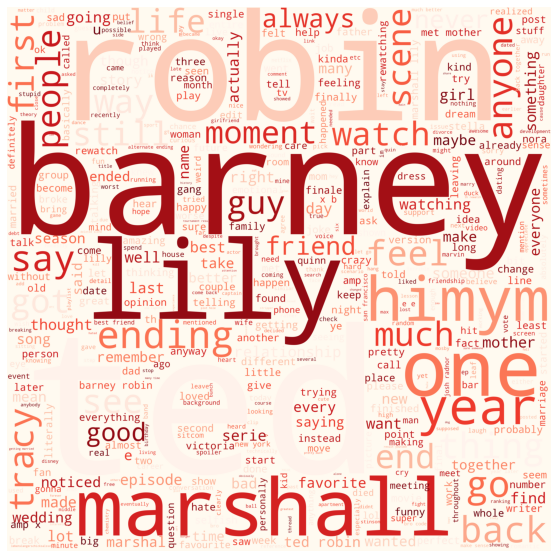

In [80]:
draw_wordcloud(data[data.subreddit==1].clean_text)

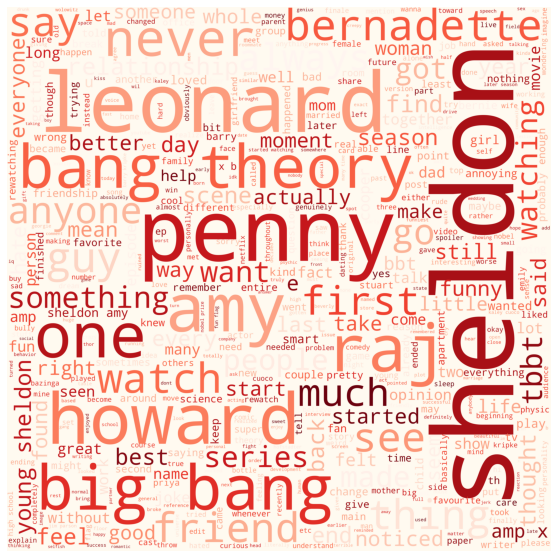

In [81]:
draw_wordcloud(data[data.subreddit==0].clean_text)

### Word Counts

In the word count we can see that the most repeated words are mostly characters from each shows:

In [523]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvec = CountVectorizer(stop_words='english')

tvec = TfidfVectorizer(stop_words='english')

In [524]:
#himym cvec count
cvec_himym = cvec.fit_transform(data[data.subreddit==1].clean_text)
cvec_df = pd.DataFrame(cvec_himym.todense(),columns=cvec.get_feature_names())
cvec_himym_count = cvec_df.sum(axis=0)
cvec_himym_count.sort_values(ascending=False).head(10)

ted         489
robin       364
barney      334
lily        191
marshall    180
himym       162
ending      118
year         99
scene        91
tracy        88
dtype: int64

In [525]:
#himym tvec count
tvec_himym = tvec.fit_transform(data[data.subreddit==1].clean_text)
tvec_df = pd.DataFrame(tvec_himym.todense(),columns=tvec.get_feature_names())
tvec_himym_count = tvec_df.sum(axis=0)
tvec_himym_count.sort_values(ascending=False).head(10)

ted         36.378108
barney      31.112751
robin       29.905098
himym       20.949044
marshall    20.157860
lily        18.623875
view        18.347154
scene       16.384731
ending      14.562348
best        12.359381
dtype: float64

In [526]:
#bigbang cvec count
cvec_bbt = cvec.fit_transform(data[data.subreddit==0].clean_text)
cvec_df = pd.DataFrame(cvec_bbt.todense(),columns=cvec.get_feature_names())
cvec_bbt_count = cvec_df.sum(axis=0)
cvec_bbt_count.sort_values(ascending=False).head(10)

sheldon    547
penny      255
leonard    238
howard     162
amy        157
big        150
raj        147
bang       138
theory     135
guy         79
dtype: int64

In [527]:
#bigbang tvec count
tvec_bbt = tvec.fit_transform(data[data.subreddit==0].clean_text)
tvec_df = pd.DataFrame(tvec_bbt.todense(),columns=tvec.get_feature_names())
tvec_bbt_count = tvec_df.sum(axis=0)
tvec_bbt_count.sort_values(ascending=False).head(10)

sheldon    58.510322
penny      28.611647
leonard    26.874159
big        23.211215
bang       22.892721
howard     22.720196
theory     22.135693
view       18.799604
raj        18.620969
best       16.697760
dtype: float64

In [528]:
def word_count(cvec_data,tvec_data,title1,title2):
    plt.figure(figsize=(22,16), facecolor='white')

    plt.subplot(2,2,1)
    cvec_data.sort_values().tail(10).plot(kind='barh')
    plt.title(title1)
    plt.xlabel('Count')
    plt.ylabel('Word')

    plt.subplot(2,2,2)
    tvec_data.sort_values().tail(10).plot(kind='barh')
    plt.title(title2)
    plt.xlabel('TFIDF Value')
    plt.ylabel('Word')

    plt.tight_layout()

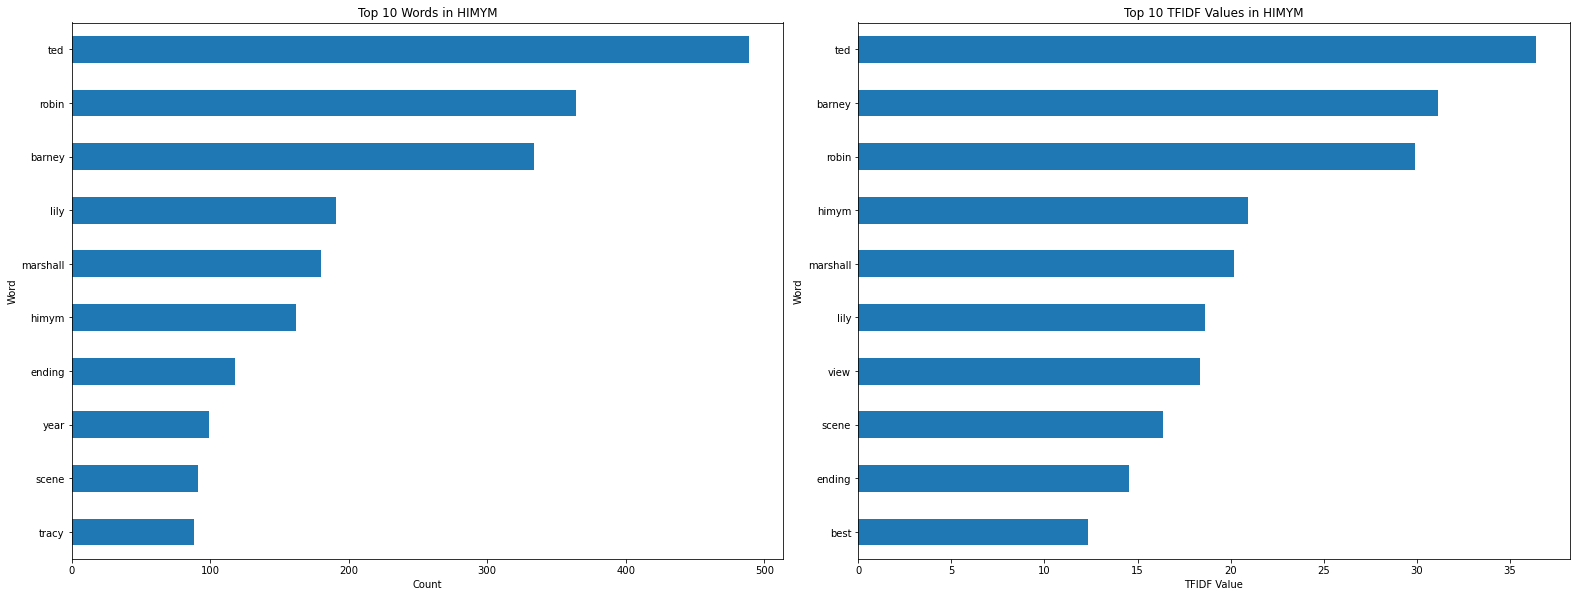

In [529]:
word_count(cvec_data=cvec_himym_count,tvec_data=tvec_himym_count,title1='Top 10 Words in HIMYM',title2='Top 10 TFIDF Values in HIMYM')

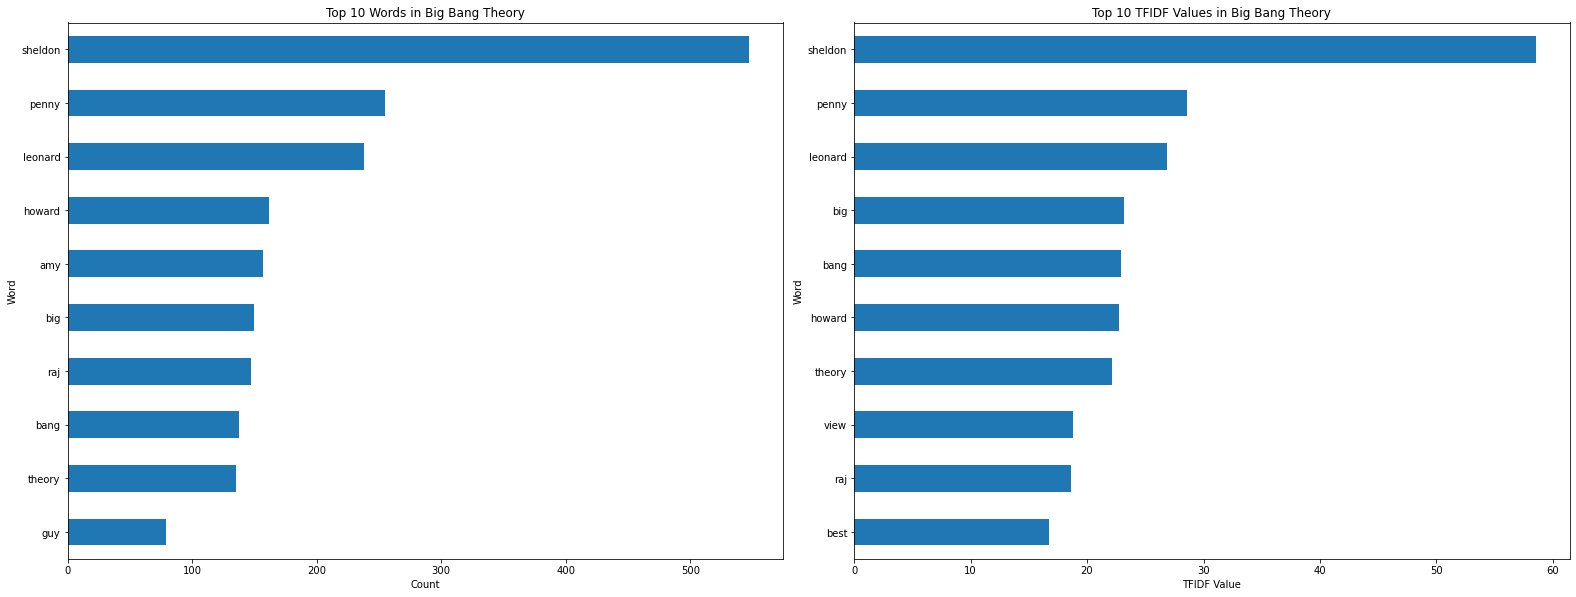

In [530]:
word_count(cvec_data=cvec_bbt_count,tvec_data=tvec_bbt_count,title1='Top 10 Words in Big Bang Theory',title2='Top 10 TFIDF Values in Big Bang Theory')

### Word Frequencies

The word count allow us to defined how many times a word is repeated however, it is hard to understand from just count. So I will be exploring how many time the word is repeted in proportion to the toal word count shown as frequency in %:

In [531]:
himym_freq = pd.DataFrame(cvec_himym_count)
himym_freq.reset_index(inplace=True)
himym_freq.rename(columns = {'index':'words',0:'count'},inplace = True)
himym_freq['freq'] = himym_freq['count'] / len(cvec_himym_count) * 100
himym_freq.sort_values(by='count',ascending=False, inplace=True)
himym_freq

,words,count,freq
3291,ted,489,13.230519
2753,robin,364,9.848485
257,barney,334,9.036797
1891,lily,191,5.167749
2005,marshall,180,4.870130
...,...,...,...
1606,icon,1,0.027056
1609,ideally,1,0.027056
1610,identify,1,0.027056
1611,identity,1,0.027056


In [532]:
bbt_freq = pd.DataFrame(cvec_bbt_count)
bbt_freq.reset_index(inplace=True)
bbt_freq.rename(columns = {'index':'words',0:'count'},inplace = True)
bbt_freq['freq'] = bbt_freq['count'] / len(cvec_bbt_count) * 100
bbt_freq.sort_values(by='count',ascending=False, inplace=True)
bbt_freq

,words,count,freq
3075,sheldon,547,14.304393
2476,penny,255,6.668410
1994,leonard,238,6.223849
1682,howard,162,4.236402
127,amy,157,4.105649
...,...,...,...
964,disappeared,1,0.026151
2305,nicety,1,0.026151
2304,nicer,1,0.026151
2303,niceguys,1,0.026151


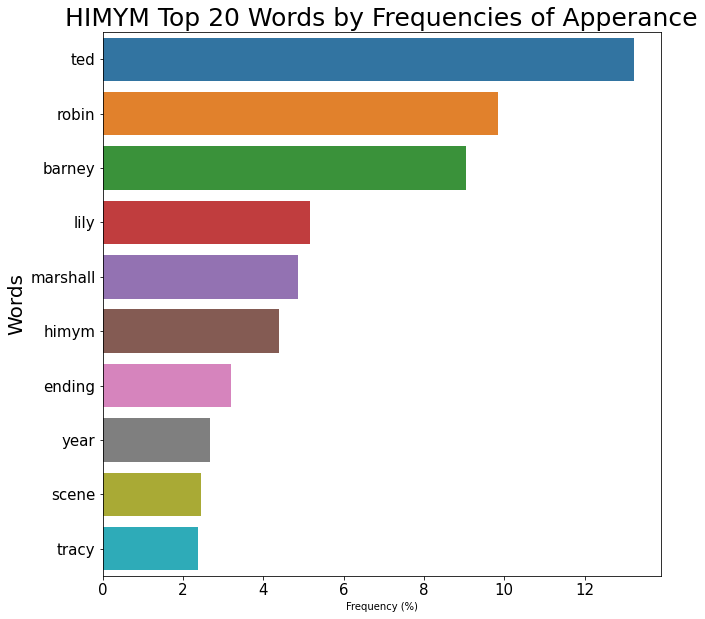

In [533]:
plt.figure(figsize=(10,10))
plt.title('HIMYM Top 20 Words by Frequencies of Apperance',fontsize=25)

sns.barplot(data=himym_freq.head(10),x='freq',y='words',orient='h')

plt.xlabel('Frequency (%)',fontsize=10)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

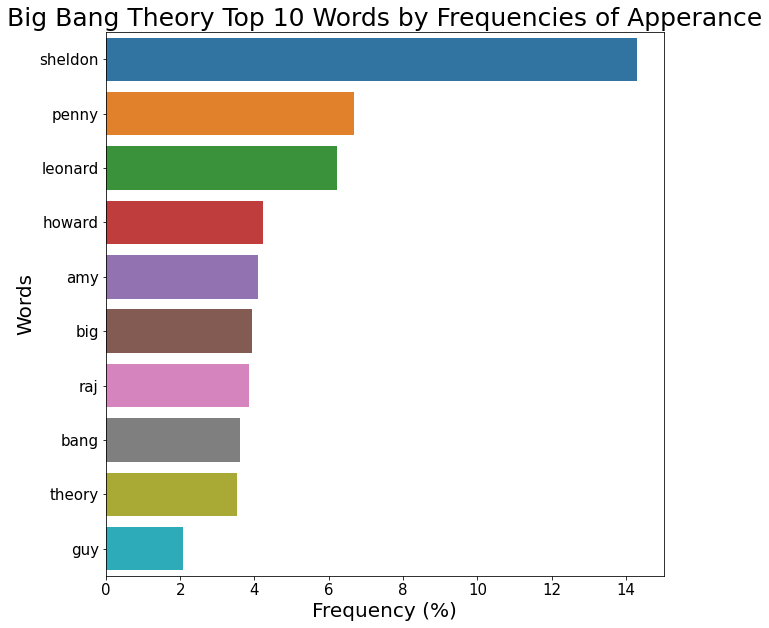

In [534]:
plt.figure(figsize=(10,10))
plt.title('Big Bang Theory Top 10 Words by Frequencies of Apperance',fontsize=25)

sns.barplot(data=bbt_freq.head(10),x='freq',y='words',orient='h')

plt.xlabel('Frequency (%)',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

### Venn Diagram

By knowing the count and frquency of each words we see that there are some trends in what shows up more often like character names or location names. So I wonder if there are any over lapping words from both shows:

In [535]:
set1 = set(himym_freq.words.head(20))
set2 = set(bbt_freq.words.head(20))

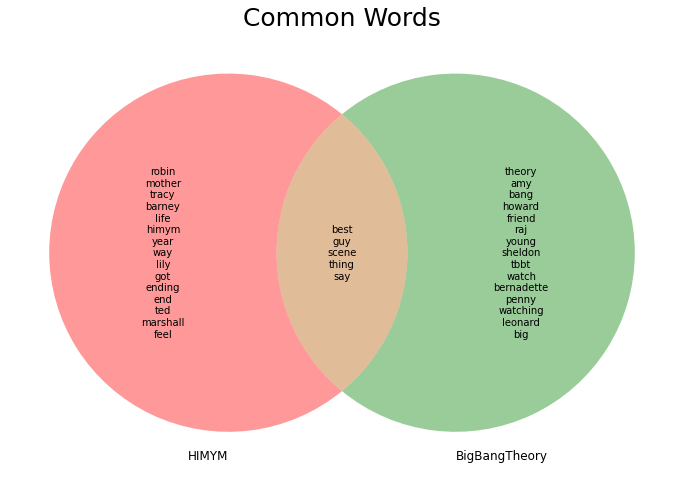

In [536]:
plt.figure(figsize=(12,10))
plt.title('Common Words',fontsize=25)   

venn = venn2([set1, set2], ("HIMYM", "BigBangTheory"))
venn.get_label_by_id('10').set_text('\n'.join(set1-set2))
venn.get_label_by_id('01').set_text('\n'.join(set2-set1))
venn.get_label_by_id('11').set_text('\n'.join(set2&set1))

From the first venn diagram produced there were overlapping words that can be removed to make the estimations better including words like: think, make, love, like, time, really, know.

---

# Modeling

In this section I will be using estimators to create prediction models to predict which posts belong in which subreddit. I have create a modeling fuction called 'modeling' that automates different estimators and vectorized with customized parameters input, and print out each model accuracy score. 

The model is being judged on their accuracy score and confusion matrix.

In [537]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,  ElasticNet
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix

In [538]:
# Get the number of reviews based on the dataframe size.
total_posts = data.shape[0]
print(f'There are {total_posts} reddit posts.')

There are 1881 reddit posts.


In [539]:
X = data[['clean_text']]
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [540]:
clean_text_train=[]
clean_text_test=[]

for text in X_train['clean_text']:
    clean_text_train.append(text)
    

for text in X_test['clean_text']:
    clean_text_test.append(text)

In [541]:
def modeling(estimator,vectorizer,y_train,max_features=None, min_df=1, max_df=1.0, ngram_range=(1,1),n_neighbors=5):
    print('Estimator Used:', estimator)
    print('Vectorizer:', vectorizer)
    
    # Instantiate the transformer.
    cvec = CountVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features=max_features,
                           min_df=min_df,
                           max_df=max_df,
                           ngram_range=ngram_range) 

    tvec = TfidfVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features=max_features,
                           min_df=min_df,
                           max_df=max_df,
                           ngram_range=ngram_range)
    if vectorizer == 'cvec':
        train_data_features = cvec.fit_transform(clean_text_train)
        test_data_features = cvec.transform(clean_text_test)
        print('Train Data Shape',train_data_features.shape)
        print('Test Data Shape',test_data_features.shape)
        
    elif vectorizer == 'tvec':
        train_data_features = tvec.fit_transform(clean_text_train)
        test_data_features = tvec.transform(clean_text_test)
        print('Train Data Shape',train_data_features.shape)
        print('Test Data Shape',test_data_features.shape)
    
    if estimator == 'log':
        log = LogisticRegression(solver = 'lbfgs')
        log.fit(train_data_features, y_train)
        print('Train Logistic regression Accuracy:', cross_val_score(log,train_data_features,y_train,cv=5).mean())
        print('Test Logistic regression Accuracy:', cross_val_score(log,test_data_features, y_test,cv=5).mean())
        return log.predict(test_data_features)
    
    elif estimator == 'knn':
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(train_data_features, y_train)
        print('Train KNN regression Accuracy:', cross_val_score(knn,train_data_features,y_train,cv=5).mean())
        print('Test KNN regression Accuracy:', cross_val_score(knn,test_data_features, y_test,cv=5).mean())
        return knn.predict(test_data_features)
        
    elif estimator == 'bayes':
        nb = MultinomialNB()
        nb.fit(train_data_features, y_train)
        print('Train Naive Bayes regression Accuracy:', cross_val_score(nb,train_data_features,y_train,cv=5).mean())
        print('Test Naive Bayes regression Accuracy:', cross_val_score(nb,test_data_features, y_test,cv=5).mean())
        return nb.predict(test_data_features)

    else:
        print('ERROR Parameters')

In [542]:
#Creating a Confusion Matrix to understand the prediction
def confusion_eval(y_test,prediction):
    tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()

    print('All Data:', len(y_test))
    print('Correctly Predict that the post is from HIMYM (TP):',tp)
    print('Correctly Predict that the post is from Big Bang Theory (TN):',tn)
    print('Incorrectly Predict that the post is from HIMYM (FP):',fp)
    print('Incorrectly Predict that the post is from Big Bang Theory (FN):',fn)

In [543]:
def confusion_score(y_test,prediction):
    tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
    
    print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
    print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
    print('Precision: {}'.format(round(tp/(tp+fp),4)))
    print('Recall: {}'.format(round(tp/(tp+fn),4)))
    print('Specificity: {}'.format(round(tn/(tn+fp),4)))

### Logistic Regression

First we will explore Logistic Regression, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre.

In [544]:
#getting accuracy score
predict_log_tvec = modeling(estimator='log',vectorizer='tvec',y_train=y_train)

Estimator Used: log
Vectorizer: tvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train Logistic regression Accuracy: 0.8576965669988926
Test Logistic regression Accuracy: 0.8197543859649123


In [545]:
predict_log_cvec = modeling(estimator='log',vectorizer='cvec',y_train=y_train)

Estimator Used: log
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train Logistic regression Accuracy: 0.8636788482834994
Test Logistic regression Accuracy: 0.8170526315789474


In [546]:
predict_log_3000 = modeling(estimator='log',vectorizer='cvec',y_train=y_train,max_features=3000)

Estimator Used: log
Vectorizer: cvec
Train Data Shape (1504, 3000)
Test Data Shape (377, 3000)
Train Logistic regression Accuracy: 0.8636788482834994
Test Logistic regression Accuracy: 0.8250175438596491


In [547]:
predict_log_min20 = modeling(estimator='log',vectorizer='cvec',y_train=y_train,max_features=3000, min_df=20)

Estimator Used: log
Vectorizer: cvec
Train Data Shape (1504, 218)
Test Data Shape (377, 218)
Train Logistic regression Accuracy: 0.8344163898117387
Test Logistic regression Accuracy: 0.7905964912280702


##### Evaluate Logistic Model

From above we see that using CountVectorizer with 3000 as max_features and 20 as min_df for parameters is the best vectorizor for the model which resulted in the highest test data R2 score of 0.7615697889670493 and train data R2 score of 0.8414406779661017.

However the best prediction came from the model using Count Vectorizer with its default parameters giving us the highest training R2 score of 0.8583875400824553 and training R2 score of 0.7534616808589412.

In [548]:
#Highest Training R2 Score
check = predict_log_cvec == y_test

df_pred = pd.DataFrame({'Predict Subreddit':predict_log_cvec,'Actual Subreddit':y_test, 'Check':check})
df_pred.head()

,Predict Subreddit,Actual Subreddit,Check
1113,0,0,True
593,1,1,True
598,0,1,False
743,0,1,False
1009,0,0,True


In [549]:
check.value_counts()

True     311
False     66
Name: subreddit, dtype: int64

In [550]:
confusion_eval(y_test,predict_log_cvec)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 131
Correctly Predict that the post is from Big Bang Theory (TN): 180
Incorrectly Predict that the post is from HIMYM (FP): 17
Incorrectly Predict that the post is from Big Bang Theory (FN): 49


In [551]:
confusion_score(y_test,predict_log_cvec)

Accuracy: 0.8249
Misclassification rate: 0.1751
Precision: 0.8851
Recall: 0.7278
Specificity: 0.9137


In [552]:
#Highest Testing R2 Score
check = predict_log_min20 == y_test

df_pred = pd.DataFrame({'Predict Subreddit':predict_log_min20,'Actual Subreddit':y_test, 'Check':check})
df_pred.head()

,Predict Subreddit,Actual Subreddit,Check
1113,0,0,True
593,1,1,True
598,0,1,False
743,0,1,False
1009,0,0,True


In [553]:
check.value_counts()

True     308
False     69
Name: subreddit, dtype: int64

In [554]:
confusion_eval(y_test,predict_log_min20)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 126
Correctly Predict that the post is from Big Bang Theory (TN): 182
Incorrectly Predict that the post is from HIMYM (FP): 15
Incorrectly Predict that the post is from Big Bang Theory (FN): 54


In [555]:
confusion_score(y_test,predict_log_min20)

Accuracy: 0.817
Misclassification rate: 0.183
Precision: 0.8936
Recall: 0.7
Specificity: 0.9239


### Adjusting Logistic Regression Model

The logistic regression model with the highest training accuracy score does appear to be somewhat overfit, inferring training data with 83% accuracy while only predicting test data with 80% accuracy.

Looking at the confusion martrix, more HIMYM (133 posts) posts were misclassfied as Big Bang Theory posts (178 posts). Now we will adjust the model parameters:

In [556]:
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = None,
                       preprocessor = None,
                       stop_words = None,
                       max_features=None,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,1)) 

In [557]:
train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)
print('Train Data Shape',train_data_features.shape)
print('Test Data Shape',test_data_features.shape)

Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)


##### Logistic Regression Hyperparameters Tuning

In [558]:
log = LogisticRegression()

In [559]:
log.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [560]:
log_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2','l1'],
    'C': np.logspace(-4, 4, 50)
}

In [561]:
log_gridsearch = GridSearchCV(log,log_params, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)

In [562]:
log_gridsearch.fit(train_data_features, y_train)

log_gridsearch.best_score_

0.864343300110742

In [563]:
log_gridsearch.best_params_

{'C': 1.2067926406393288, 'penalty': 'l2', 'solver': 'newton-cg'}

In [564]:
log_gridsearch.score(test_data_features, y_test)

0.8249336870026526

In [565]:
predict_log_grid = log_gridsearch.predict(test_data_features)

check = predict_log_grid == y_test
check.value_counts()

True     311
False     66
Name: subreddit, dtype: int64

In [566]:
confusion_eval(y_test,predict_log_grid)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 131
Correctly Predict that the post is from Big Bang Theory (TN): 180
Incorrectly Predict that the post is from HIMYM (FP): 17
Incorrectly Predict that the post is from Big Bang Theory (FN): 49


In [567]:
confusion_score(y_test,predict_log_grid)

Accuracy: 0.8249
Misclassification rate: 0.1751
Precision: 0.8851
Recall: 0.7278
Specificity: 0.9137


Through customized paramter setting for logistic regression using GridSearch CV, the best parameters were:
- CountVectorizer
- Logistic Regression
    - 'C': 0.5689866029018293
    - 'penalty': 'l2'
    - 'solver': 'newton-cg'}

### KNN Regression

Now we will explore KNN Regression, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre.

In [568]:
knn_tvec = modeling(estimator='knn',vectorizer='tvec',y_train=y_train)

Estimator Used: knn
Vectorizer: tvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.5325559246954595
Test KNN regression Accuracy: 0.5701052631578948


In [569]:
knn_cvec_n5 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.7240420819490587
Test KNN regression Accuracy: 0.6840701754385965


In [570]:
knn_cvec_n10 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=10)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.678859357696567
Test KNN regression Accuracy: 0.7163508771929825


In [571]:
knn_cvec_n20 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=20)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.6535836101882614
Test KNN regression Accuracy: 0.6711578947368422


In [572]:
knn_cvec_n25 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=25)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.6562547065337763
Test KNN regression Accuracy: 0.6790175438596491


In [573]:
knn_cvec_n30 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=30)

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train KNN regression Accuracy: 0.642954595791805
Test KNN regression Accuracy: 0.6420350877192983


In [574]:
knn_cvec_n25 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=20,max_features=3000,ngram_range=(1,2))

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 3000)
Test Data Shape (377, 3000)
Train KNN regression Accuracy: 0.6675592469545958
Test KNN regression Accuracy: 0.6367368421052633


In [575]:
knn_cvec_n25 = modeling(estimator='knn',vectorizer='cvec',y_train=y_train,n_neighbors=20,max_features=3000,min_df=2, max_df=0.9,ngram_range=(1,2))

Estimator Used: knn
Vectorizer: cvec
Train Data Shape (1504, 3000)
Test Data Shape (377, 3000)
Train KNN regression Accuracy: 0.6622325581395349
Test KNN regression Accuracy: 0.6501052631578947


##### Evaluate KNN Model

From above we see that using CountVectorizer and its default parameters is the best vectorizor for the model in combination with using 20 as N nearest neighbors resulting in the highest test data R2 score of 0.6830433172898926 and the train data R2 score of 0.7188021071919377. 

In [576]:
check = knn_cvec_n20 == y_test

df_pred = pd.DataFrame({'Predict Subreddit':knn_cvec_n20,'Actual Subreddit':y_test, 'Check':check})
df_pred.head()

,Predict Subreddit,Actual Subreddit,Check
1113,0,0,True
593,0,1,False
598,0,1,False
743,0,1,False
1009,0,0,True


In [577]:
check.value_counts()

True     239
False    138
Name: subreddit, dtype: int64

In [578]:
confusion_eval(y_test,knn_cvec_n20)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 42
Correctly Predict that the post is from Big Bang Theory (TN): 197
Incorrectly Predict that the post is from HIMYM (FP): 0
Incorrectly Predict that the post is from Big Bang Theory (FN): 138


In [579]:
confusion_score(y_test,knn_cvec_n20)

Accuracy: 0.634
Misclassification rate: 0.366
Precision: 1.0
Recall: 0.2333
Specificity: 1.0


### Adjusting KNN

The KNN regression predicting the data with 62% accuracy.

Looking at the confusion martrix, less HIMYM (38 posts) posts were misclassfied as Big Bang Theory posts (197 posts). Now we will adjust the model parameters:

In [580]:
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = None,
                       preprocessor = None,
                       stop_words = None,
                       max_features=None,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,1)) 

In [581]:
train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)
print('Train Data Shape',train_data_features.shape)
print('Test Data Shape',test_data_features.shape)

Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)


##### KNN Estimator Hyperparameters Tuning

In [582]:
knn = KNeighborsClassifier()

In [583]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [584]:
knn_params = {
    'n_neighbors': range(1, 50, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [585]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(knn,knn_params, cv=5, verbose=1)

In [586]:
knn_gridsearch.fit(train_data_features, y_train)

knn_gridsearch.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


0.761295681063123

In [587]:
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

In [588]:
knn_gridsearch.score(test_data_features, y_test)

0.7506631299734748

In [589]:
predict_knn_grid = knn_gridsearch.predict(test_data_features)

check = predict_knn_grid == y_test
check.value_counts()

True     283
False     94
Name: subreddit, dtype: int64

In [590]:
confusion_eval(y_test,predict_knn_grid)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 104
Correctly Predict that the post is from Big Bang Theory (TN): 179
Incorrectly Predict that the post is from HIMYM (FP): 18
Incorrectly Predict that the post is from Big Bang Theory (FN): 76


In [591]:
confusion_score(y_test,predict_knn_grid)

Accuracy: 0.7507
Misclassification rate: 0.2493
Precision: 0.8525
Recall: 0.5778
Specificity: 0.9086


Through customized paramter setting for KNN regression using GridSearch CV allowed the accuracy to increase to 75%, the best parameters were:
- CountVectorizer
- Logistic Regression
    - 'metric': 'euclidean'
    - 'n_neighbors': 1
    - 'weights': 'uniform'

### Naive Bayes Estimator

Lastly we will explore Naive Bayes Estimator, starting by comparing the vectorizor to see which gives the best accuracy score and will be using that as the default vectorizer and adjust the parameters to find the highest accuracy socre.

In [592]:
bayes_tvec = modeling(estimator='bayes',vectorizer='tvec',y_train=y_train)

Estimator Used: bayes
Vectorizer: tvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train Naive Bayes regression Accuracy: 0.8663433001107419
Test Naive Bayes regression Accuracy: 0.8145263157894738


In [593]:
bayes_cvec = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)
Train Naive Bayes regression Accuracy: 0.8643521594684385
Test Naive Bayes regression Accuracy: 0.8411228070175438


In [594]:
bayes_3000 = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train,max_features=3000)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (1504, 3000)
Test Data Shape (377, 3000)
Train Naive Bayes regression Accuracy: 0.8670121816168328
Test Naive Bayes regression Accuracy: 0.8490526315789474


In [595]:
bayes_min2 = modeling(estimator='bayes',vectorizer='cvec',y_train=y_train,max_features=3000,min_df=2)

Estimator Used: bayes
Vectorizer: cvec
Train Data Shape (1504, 2421)
Test Data Shape (377, 2421)
Train Naive Bayes regression Accuracy: 0.8663499446290144
Test Naive Bayes regression Accuracy: 0.8437543859649124


##### Evaluate Naive Bayes Estimator

From above we see that using CountVectorizer with its parameters at max_features=3000 and min_df=2 is the best vectorizor for the Bayes model resulting in the highest test data R2 score of 0.7859311366160682 and the train data R2 score of 0.8631310123683005.

However for adjusting consistancy we will input CountVectorizer default parameters.

In [596]:
check = bayes_min2 == y_test

df_pred = pd.DataFrame({'Predict Subreddit':bayes_min2,'Actual Subreddit':y_test, 'Check':check})
df_pred.head()

,Predict Subreddit,Actual Subreddit,Check
1113,0,0,True
593,1,1,True
598,1,1,True
743,0,1,False
1009,0,0,True


In [597]:
check.value_counts()

True     322
False     55
Name: subreddit, dtype: int64

In [598]:
confusion_eval(y_test,bayes_min2)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 153
Correctly Predict that the post is from Big Bang Theory (TN): 169
Incorrectly Predict that the post is from HIMYM (FP): 28
Incorrectly Predict that the post is from Big Bang Theory (FN): 27


In [599]:
confusion_score(y_test,bayes_min2)

Accuracy: 0.8541
Misclassification rate: 0.1459
Precision: 0.8453
Recall: 0.85
Specificity: 0.8579


### Adjusting Naive Bayes Model

The naive bayes regression model predicting test data with 85% accuracy.

Looking at the confusion martrix, less HIMYM (154 posts) posts were misclassfied as Big Bang Theory posts (169 posts). Now we will adjust the model parameters:

In [600]:
cvec = CountVectorizer(analyzer = "word",
                       tokenizer = None,
                       preprocessor = None,
                       stop_words = None,
                       max_features=None,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,1))

In [601]:
train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)
print('Train Data Shape',train_data_features.shape)
print('Test Data Shape',test_data_features.shape)

Train Data Shape (1504, 5322)
Test Data Shape (377, 5322)


##### Naive Bayes Hyperparameters Tuning

In [602]:
nb = MultinomialNB()

In [603]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [604]:
nb_params = {
    'alpha': np.linspace(0.5, 1.5, 6),
    'fit_prior': [True, False],  
}

In [605]:
nb_gridsearch = GridSearchCV(MultinomialNB(), nb_params)

In [606]:
nb_gridsearch.fit(train_data_features, y_train)

nb_gridsearch.best_score_

0.8690121816168329

In [607]:
nb_gridsearch.best_params_

{'alpha': 0.7, 'fit_prior': True}

In [608]:
nb_gridsearch.score(test_data_features, y_test)

0.8647214854111406

In [609]:
predict_nb_grid = nb_gridsearch.predict(test_data_features)

check = predict_nb_grid == y_test
check.value_counts()

True     326
False     51
Name: subreddit, dtype: int64

In [610]:
confusion_eval(y_test,predict_nb_grid)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 158
Correctly Predict that the post is from Big Bang Theory (TN): 168
Incorrectly Predict that the post is from HIMYM (FP): 29
Incorrectly Predict that the post is from Big Bang Theory (FN): 22


In [611]:
# Examine some classification metrics 
confusion_score(y_test,predict_nb_grid)

Accuracy: 0.8647
Misclassification rate: 0.1353
Precision: 0.8449
Recall: 0.8778
Specificity: 0.8528


Through customized paramter setting for Naive Bayes Estimators using GridSearch CV, the best parameters were:
- CountVectorizer
- Logistic Regression
    - 'alpha': 0.7
    - 'fit_prior': True

---

# Evaluation and Best Model

From exploring each model score and its corresponding confusion matrix; we are able to identify that the best model for word prediction is Naive Bayes estimator at alpha equals to 0.7, fit_prior is True with deafult Count Vectorizer. 

### Confusion Matrix Evaluation

In [612]:
check = predict_nb_grid == y_test
check.value_counts()

True     326
False     51
Name: subreddit, dtype: int64

In [613]:
pd.DataFrame(predict_nb_grid)

,0
0,0
1,1
2,1
3,0
4,0
...,...
372,0
373,1
374,1
375,0


In [614]:
confusion_eval(y_test,predict_nb_grid)

All Data: 377
Correctly Predict that the post is from HIMYM (TP): 158
Correctly Predict that the post is from Big Bang Theory (TN): 168
Incorrectly Predict that the post is from HIMYM (FP): 29
Incorrectly Predict that the post is from Big Bang Theory (FN): 22


In [615]:
best_model = pd.DataFrame(confusion_matrix(y_test,predict_nb_grid),
                          columns=['predict Big Bang Theory', 'predict HIMYM'],
                          index=['actual Big Bang Theory', 'actual HIMYM'])
best_model

,predict Big Bang Theory,predict HIMYM
actual Big Bang Theory,168,29
actual HIMYM,22,158


In [616]:
# Examine some classification metrics 
confusion_score(y_test,predict_nb_grid)

Accuracy: 0.8647
Misclassification rate: 0.1353
Precision: 0.8449
Recall: 0.8778
Specificity: 0.8528


From looking at the confusion matrix we can say that our best model can:

- Our model predict 86% of the observations
- Among the posts that the model predicted 83% were correctly classified as HIMYM posts
- Among the posts that are in HIMYM, the model has 88% correctly classified
- Among the posts that are in The Big Bang Theory, the model has 83% correctly classified

### Log Probability of Features Evaluation

From the confusion matrix evaluation I want to explore deeper into each words and how much effect different words have on the predictions.

In [617]:
cvec = CountVectorizer()
nb = MultinomialNB(alpha=0.7,fit_prior=True)

train_data_features = cvec.fit_transform(clean_text_train)
test_data_features = cvec.transform(clean_text_test)

nb.fit(train_data_features,y_train)

print('Train Naive Bayes regression Accuracy:', cross_val_score(nb,train_data_features,y_train,cv=5).mean())
print('Test Naive Bayes regression Accuracy:', cross_val_score(nb,test_data_features, y_test,cv=5).mean())

Train Naive Bayes regression Accuracy: 0.8690121816168329
Test Naive Bayes regression Accuracy: 0.8437543859649124


In [618]:
# Create a word count data frame
count_df = pd.DataFrame(test_data_features.todense(),columns=cvec.get_feature_names())
count_df

,abby,abigail,ability,able,abruptly,absence,absolute,absolutely,absurd,abuse,...,zack,zapka,zazzy,zinger,zinman,zoey,zoeys,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [619]:
nb.feature_log_prob_

array([[-10.16400396, -10.16400396,  -9.27670076, ...,  -8.81407724,
        -10.16400396, -10.16400396],
       [ -9.30978105,  -9.30978105, -10.19708424, ..., -10.19708424,
         -9.30978105,  -9.30978105]])

In [620]:
nb_eval = pd.DataFrame(data={'HIMYM':nb.feature_log_prob_[0],'BigBangTheory':nb.feature_log_prob_[1],'Word':count_df.columns})

nb_eval

,HIMYM,BigBangTheory,Word
0,-10.164004,-9.309781,abby
1,-10.164004,-9.309781,abigail
2,-9.276701,-10.197084,ability
3,-7.347740,-7.677086,able
4,-9.276701,-10.197084,abruptly
...,...,...,...
5317,-10.164004,-8.099943,zoey
5318,-10.164004,-9.309781,zoeys
5319,-8.814077,-10.197084,zone
5320,-10.164004,-9.309781,zoo


In [621]:
nb_eval['EvalScore'] = nb_eval['HIMYM'] - nb_eval['BigBangTheory']

In [622]:
nb_eval.sort_values(by='EvalScore').head(20) #if eval score is more negative the word leans towards HIMYM

,HIMYM,BigBangTheory,Word,EvalScore
4714,-10.164004,-3.869913,ted,-6.294091
4000,-10.164004,-4.147688,robin,-6.016316
401,-10.164004,-4.261812,barney,-5.902192
2746,-10.164004,-4.694661,lily,-5.469343
2897,-10.164004,-4.760870,marshall,-5.403134
4859,-10.164004,-5.487554,tracy,-4.676450
2215,-9.276701,-4.982925,himym,-4.293776
2896,-10.164004,-6.322911,marshal,-3.841092
5077,-10.164004,-6.674934,victoria,-3.489070
4512,-10.164004,-7.086749,stella,-3.077255


In [623]:
plothead = nb_eval[['Word','EvalScore']]
plothead.sort_values(by='EvalScore').head(20)

,Word,EvalScore
4714,ted,-6.294091
4000,robin,-6.016316
401,barney,-5.902192
2746,lily,-5.469343
2897,marshall,-5.403134
4859,tracy,-4.676450
2215,himym,-4.293776
2896,marshal,-3.841092
5077,victoria,-3.489070
4512,stella,-3.077255


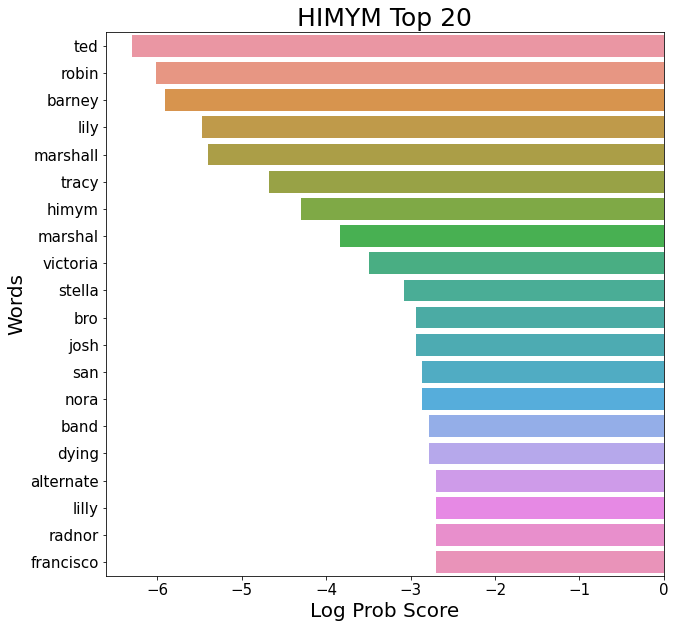

In [624]:
plt.figure(figsize=(10,10))
plt.title('HIMYM Top 20',fontsize=25)

sns.barplot(data=nb_eval.sort_values(by='EvalScore').head(20),x='EvalScore',y='Word',orient='h')

plt.xlabel('Log Prob Score',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

In [625]:
nb_eval.sort_values(by='EvalScore',ascending=False).head(20) #if the eval score is more positive the word leans towards Big Bang Theory

,HIMYM,BigBangTheory,Word,EvalScore
4220,-3.696527,-10.197084,sheldon,6.500557
2715,-4.510513,-10.197084,leonard,5.686571
176,-4.965507,-10.197084,amy,5.231577
3401,-4.480910,-9.309781,penny,4.828871
468,-5.701385,-10.197084,bernadette,4.495699
2283,-5.039190,-9.309781,howard,4.270591
3769,-5.073766,-9.309781,raj,4.236015
425,-6.351012,-10.197084,bbt,3.846072
403,-6.560838,-10.197084,barry,3.636246
1006,-6.641854,-10.197084,cooper,3.555230


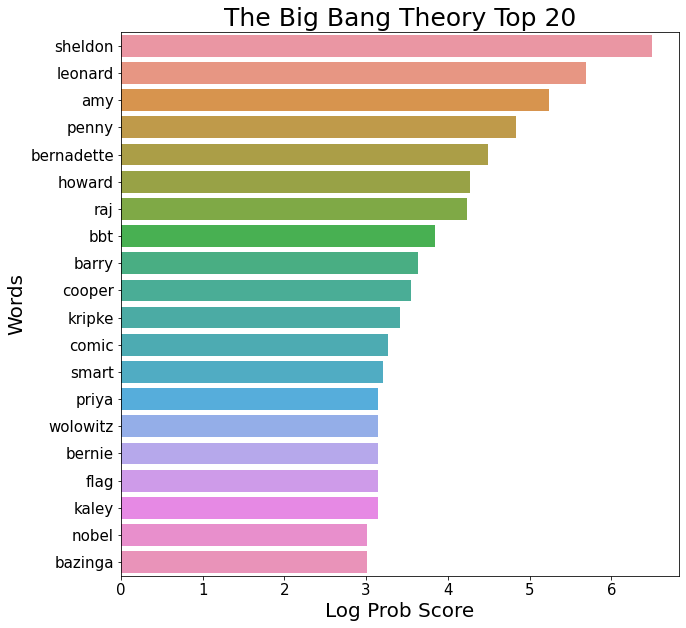

In [626]:
plt.figure(figsize=(10,10))
plt.title('The Big Bang Theory Top 20',fontsize=25)

sns.barplot(data=nb_eval.sort_values(by='EvalScore',ascending=False).head(20).head(20),x='EvalScore',y='Word',orient='h')

plt.xlabel('Log Prob Score',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

From the log probability evaluation I calculated the eval score where the more positive the number the more that word leans to predicting the post as The Big Bang Theory subreddit, while the more negative the number the more that word leans to predicting the post as HIMYM subreddit.

### Wrong Words Search Evaluation

Following the above evaluation I wanted to combine what I learned from the confusion matrix and lof probability eval score to see where the false predicting post are and what words are consisted in the posts.

In [627]:
word_search = pd.DataFrame(data={'predict_value':predict_nb_grid,'actual_value':y_test,'text':clean_text_test})
word_search

,predict_value,actual_value,text
1113,0,0,consistent show tbbt one show progress story l...
593,1,1,e year get holographic phone
598,1,1,band horse funeral e
743,0,1,favorite friendship show view
1009,0,0,tbbt actor globe amy pohler joke big bazinga c...
...,...,...,...
1758,0,0,old someone help trying work age mention penny...
339,1,1,got favorite scene tattooed week ago
561,1,1,playbook finished reading barney playbook lege...
1733,0,0,least intelligent four main guy would rank leo...


In [628]:
word_search['incorrect_prediction'] = word_search['predict_value'] - word_search['actual_value']
word_search

,predict_value,actual_value,text,incorrect_prediction
1113,0,0,consistent show tbbt one show progress story l...,0
593,1,1,e year get holographic phone,0
598,1,1,band horse funeral e,0
743,0,1,favorite friendship show view,-1
1009,0,0,tbbt actor globe amy pohler joke big bazinga c...,0
...,...,...,...,...
1758,0,0,old someone help trying work age mention penny...,0
339,1,1,got favorite scene tattooed week ago,0
561,1,1,playbook finished reading barney playbook lege...,0
1733,0,0,least intelligent four main guy would rank leo...,0


In [629]:
wrong_word_search1 = word_search[word_search['incorrect_prediction'] ==1]
wrong_word_search2 = word_search[word_search['incorrect_prediction'] == -1]

wrong_word_data = [wrong_word_search1, wrong_word_search2]

wrong_word = pd.concat(wrong_word_data)

wrong_word

,predict_value,actual_value,text,incorrect_prediction
1548,1,0,stop best show literally laugh loud watch eith...,1
1553,1,0,question every dnd dice ever something dm roll...,1
1455,1,0,breakup scene,1
1805,1,0,vote favorite,1
1694,1,0,mention one favorite shammy scene,1
1721,1,0,president seibert cop shameless,1
1704,1,0,help step roommate get butter,1
1198,1,0,fish nightlamps come true,1
1562,1,0,got game present amazing,1
1386,1,0,depth blog post food eat,1


In [630]:
wrong_word.shape

(51, 4)

In [631]:
wrong_text=[]

for text in wrong_word['text']:
    wrong_text.append(text_to_words(text))

In [632]:
wrong_text[0]

'stop best show literally laugh loud watch either covid made crazy show keep going crazy'

In [633]:
testing = wrong_text[0].split()
testing

['stop',
 'best',
 'show',
 'literally',
 'laugh',
 'loud',
 'watch',
 'either',
 'covid',
 'made',
 'crazy',
 'show',
 'keep',
 'going',
 'crazy']

In [634]:
nb_eval.loc[(nb_eval['Word'] == 'crazy')]

,HIMYM,BigBangTheory,Word,EvalScore
1056,-7.535203,-7.223013,crazy,-0.31219


In [635]:
words = []

for i in range(len(wrong_text)):
    word = wrong_text[i].split()
    words.append(word)

In [636]:
words

[['stop',
  'best',
  'show',
  'literally',
  'laugh',
  'loud',
  'watch',
  'either',
  'covid',
  'made',
  'crazy',
  'show',
  'keep',
  'going',
  'crazy'],
 ['question',
  'every',
  'dnd',
  'dice',
  'ever',
  'something',
  'dm',
  'roll',
  'version',
  'dnd',
  'playing'],
 ['breakup', 'scene'],
 ['vote', 'favorite'],
 ['mention', 'one', 'favorite', 'shammy', 'scene'],
 ['president', 'seibert', 'cop', 'shameless'],
 ['help', 'step', 'roommate', 'get', 'butter'],
 ['fish', 'nightlamps', 'come', 'true'],
 ['got', 'game', 'present', 'amazing'],
 ['depth', 'blog', 'post', 'food', 'eat'],
 ['anyone',
  'else',
  'watch',
  'clip',
  'youtube',
  'remeber',
  'watching',
  'show',
  'first',
  'came',
  'reason',
  'never',
  'got',
  'watching',
  'full',
  'thing',
  'though',
  'watching',
  'funnier',
  'scene',
  'youtube',
  'also',
  'thing',
  'show',
  'office',
  'anyone',
  'watch',
  'clip',
  'youtube',
  'instead',
  'full'],
 ['courtney',
  'henggeler',
  'pregnan

In [637]:
import itertools
word_list = list(itertools.chain.from_iterable(words))

word = [] 
for i in word_list: 
    if i not in word: 
        word.append(i) 
        
word

['stop',
 'best',
 'show',
 'literally',
 'laugh',
 'loud',
 'watch',
 'either',
 'covid',
 'made',
 'crazy',
 'keep',
 'going',
 'question',
 'every',
 'dnd',
 'dice',
 'ever',
 'something',
 'dm',
 'roll',
 'version',
 'playing',
 'breakup',
 'scene',
 'vote',
 'favorite',
 'mention',
 'one',
 'shammy',
 'president',
 'seibert',
 'cop',
 'shameless',
 'help',
 'step',
 'roommate',
 'get',
 'butter',
 'fish',
 'nightlamps',
 'come',
 'true',
 'got',
 'game',
 'present',
 'amazing',
 'depth',
 'blog',
 'post',
 'food',
 'eat',
 'anyone',
 'else',
 'clip',
 'youtube',
 'remeber',
 'watching',
 'first',
 'came',
 'reason',
 'never',
 'full',
 'thing',
 'though',
 'funnier',
 'also',
 'office',
 'instead',
 'courtney',
 'henggeler',
 'pregnancy',
 'used',
 'portray',
 'amanda',
 'cobra',
 'kai',
 'missy',
 'would',
 'spend',
 'day',
 'could',
 'view',
 'good',
 'doggy',
 'smile',
 'line',
 'mine',
 'wide',
 'eyed',
 'shell',
 'shocked',
 'survival',
 'training',
 'hoard',
 'saying',
 'ate

In [638]:
wrong_df = pd.DataFrame(columns=['Word','EvalScore'])

for i in word:
    wrong_list = nb_eval.loc[(nb_eval['Word'] == i)][['Word','EvalScore']]
    wrong_df = pd.concat([wrong_df,wrong_list])

In [639]:
wrong_list

,Word,EvalScore
3882,relate,0.348161


In [640]:
wrong_df
wrong_df.sort_values(by='EvalScore') # positive --> predict Big Bang Theory, negative --> predict HIMYM

,Word,EvalScore
541,bob,-2.225702
4514,step,-2.225702
5100,vote,-2.053687
2810,loud,-1.631927
4117,scream,-1.631927
...,...,...
3957,reunion,1.937318
4563,strong,1.937318
3016,missy,2.130221
4279,similarity,2.291863


In [641]:
bbt_wrong = wrong_df[wrong_df['EvalScore'] > 0]
bbt_wrong.sort_values(by='EvalScore').head(20)

,Word,EvalScore
257,arguably,0.033080
436,become,0.033080
3632,probably,0.033080
4740,terrible,0.033080
1624,excuse,0.033080
4717,teen,0.033080
155,amanda,0.033080
2790,long,0.033080
909,compared,0.033080
1594,every,0.033080


In [642]:
print(list(bbt_wrong.sort_values(by='EvalScore')['Word']))

['arguably', 'become', 'probably', 'terrible', 'excuse', 'teen', 'amanda', 'long', 'compared', 'every', 'age', 'totally', 'playing', 'mean', 'non', 'found', 'could', 'ever', 'true', 'would', 'made', 'mine', 'guy', 'late', 'question', 'see', 'something', 'series', 'show', 'either', 'watching', 'entire', 'laugh', 'little', 'watch', 'full', 'relate', 'shit', 'amp', 'help', 'keep', 'food', 'nothing', 'never', 'interesting', 'imagine', 'hi', 'guest', 'wise', 'actual', 'funny', 'ep', 'friendship', 'game', 'underrated', 'working', 'enough', 'cool', 'stop', 'hero', 'grand', 'winner', 'shocked', 'holy', 'announces', 'copy', 'covid', 'came', 'oscar', 'space', 'began', 'eat', 'office', 'uk', 'stuart', 'strong', 'reunion', 'missy', 'similarity', 'roommate']


In [643]:
himym_wrong = wrong_df[wrong_df['EvalScore'] < 0]
himym_wrong.sort_values(by='EvalScore').head(20)

,Word,EvalScore
4514,step,-2.225702
541,bob,-2.225702
5100,vote,-2.053687
2810,loud,-1.631927
4117,scream,-1.631927
5201,wide,-1.631927
1224,depth,-1.316846
1783,fish,-1.316846
648,butter,-1.316846
3890,release,-1.316846


In [644]:
print(list(himym_wrong.sort_values(by='EvalScore')['Word']))

['step', 'bob', 'vote', 'loud', 'scream', 'wide', 'depth', 'fish', 'butter', 'release', 'lockdown', 'post', 'clip', 'die', 'traveler', 'conversation', 'literally', 'break', 'amazing', 'youtube', 'going', 'appreciation', 'smile', 'meme', 'saying', 'butterfly', 'funnier', 'homework', 'penis', 'blog', 'lift', 'kai', 'cube', 'cop', 'dm', 'starred', 'cobra', 'pretty', 'nice', 'sure', 'wow', 'breakup', 'pregnancy', 'bad', 'used', 'away', 'feeling', 'im', 'year', 'right', 'someone', 'good', 'plan', 'making', 'picture', 'version', 'go', 'live', 'favorite', 'though', 'running', 'present', 'spend', 'scene', 'much', 'get', 'lol', 'line', 'come', 'crazy', 'reason', 'noticed', 'hope', 'maybe', 'president', 'still', 'also', 'sorry', 'definitely', 'notice', 'quote', 'idea', 'got', 'instead', 'best', 'one', 'else', 'thing', 'mind', 'view', 'everyone', 'first', 'word', 'day', 'mention', 'change', 'anyone']


Overall, the best model producted was the Naive Bayes model with Count Vectorizer. Through more evaluation we were able to identify the key words for each of the subreddit, which consisted mainly of character names and location names. 

When looking deeper we were able to identify words that are present to not lean one way or the othere where their eval score is closer to 0. These words listed above in himym_wrong and bbt_wrong can be removed through the cleaning process aswell for a better prediction result.

---

# Recommendations 

Our multinomial Naive Bayes classifier performed well with a test accuracy score of 86%. This is within expectations because out two topics have a lot of similarity in the content and genre of the shows, while still have unique character names.

Through the two models there are some words that are hard for the model to predict which were mentioned in the evaluation part where we can remove to imporve the model as well. However, not removing the words does not have a significant effect as it doesn't lean either way significantly.

From our findings the recommended words for users to search and learn more about the show on reddit or search engines would be specific chracter names, catchphrase or location names:

|HIMYM Key Words|Big Bang Theory Key Words|
|---|---|
|ted|sheldon|
|robin|penny|
|barney|leonard|
|lily|nobel|
|marshall|amy|
|time|raj|
|bro|smart|
|tracy|bernadette|
|victoria|bazinga|
|stella|comics|

# Additional Data

For future improvement on the data prediction and keywords identidication:
- Optimize stop words and explore strategies for stemming and lemmatization
- Try ensemble models, such as random forest and tree bagging classifier or adaboost
- Ability for model to classify more than two subreddits
- Gain more data to increase text content and words count
- Add more stop words and remove them from the data set